In [2]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
%run utils.ipynb

In [4]:
data = pd.read_parquet(processed_dataset_path)
#train_categorical_columns = ['course', 'gender', 'pre_existing_medical_condition']
train_categorical_columns = ['course', 'gender']
for col in train_categorical_columns:
    data[col] = data[col].astype('category')

X = data.drop('unsuccessful_outcome', axis=1)
y = data['unsuccessful_outcome'].astype(int)

In [5]:
# Splitting the dataset into train, validation, and test sets (60%, 20%, 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Grouped k-fold

In [14]:
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

# Assuming 'groups' is a column in your dataset that represents the grouping factor
groups = data['course']

# Split the dataset into a train-test set (80%, 20%)
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
groups_train_test = groups.loc[X_train_test.index]

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Placeholder for the best model and its score
best_model = None
best_score = -np.inf

# Iterate over each fold
for train_idx, valid_idx in gkf.split(X_train_test, y_train_test, groups=groups_train_test):
    # Split the data
    X_train, X_valid = X_train_test.iloc[train_idx], X_train_test.iloc[valid_idx]
    y_train, y_valid = y_train_test.iloc[train_idx], y_train_test.iloc[valid_idx]

    # Initialize CatBoostClassifier
    catboost_model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        #class_weights=[1, 4],
        random_seed=42,
        verbose=100,
        cat_features=train_categorical_columns  # Adjust this according to your dataset
    )

    # Fit model
    catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

    # Evaluate model
    y_pred_proba = catboost_model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_pred_proba)

    # Update best model if current model is better
    if roc_auc > best_score:
        best_model = catboost_model
        best_score = roc_auc

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the performance metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')


0:	test: 0.9333895	best: 0.9333895 (0)	total: 36.2ms	remaining: 36.2s
100:	test: 0.9649308	best: 0.9649308 (100)	total: 2.5s	remaining: 22.2s
200:	test: 0.9658510	best: 0.9663207 (176)	total: 5.38s	remaining: 21.4s
300:	test: 0.9649966	best: 0.9663207 (176)	total: 8.02s	remaining: 18.6s
400:	test: 0.9646909	best: 0.9663207 (176)	total: 10.6s	remaining: 15.9s
500:	test: 0.9640289	best: 0.9663207 (176)	total: 13.4s	remaining: 13.3s
600:	test: 0.9628728	best: 0.9663207 (176)	total: 16.7s	remaining: 11.1s
700:	test: 0.9621642	best: 0.9663207 (176)	total: 19.9s	remaining: 8.49s
800:	test: 0.9624902	best: 0.9663207 (176)	total: 22.9s	remaining: 5.68s
900:	test: 0.9624416	best: 0.9663207 (176)	total: 25.6s	remaining: 2.82s
999:	test: 0.9625367	best: 0.9663207 (176)	total: 29.2s	remaining: 0us

bestTest = 0.9663207295
bestIteration = 176

Shrink model to first 177 iterations.
0:	test: 0.9068781	best: 0.9068781 (0)	total: 32.6ms	remaining: 32.6s
100:	test: 0.9480313	best: 0.9492419 (86)	total: 

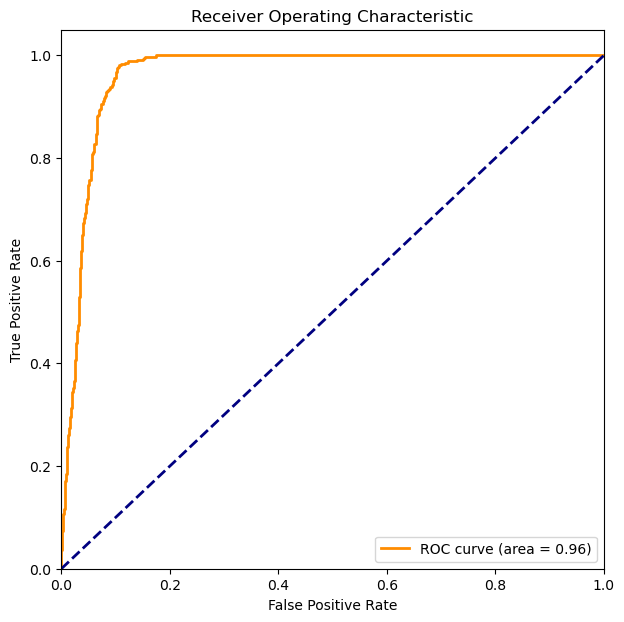

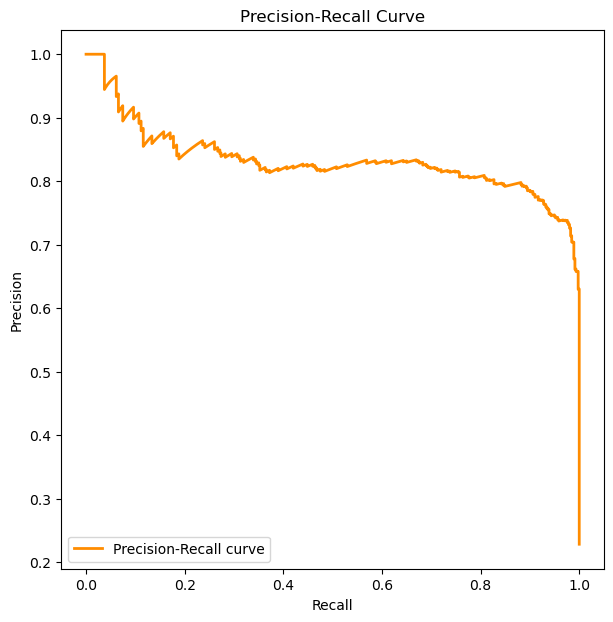

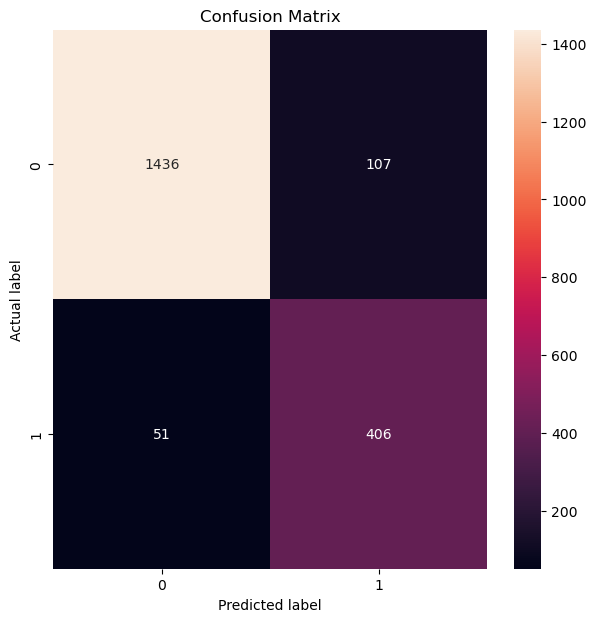

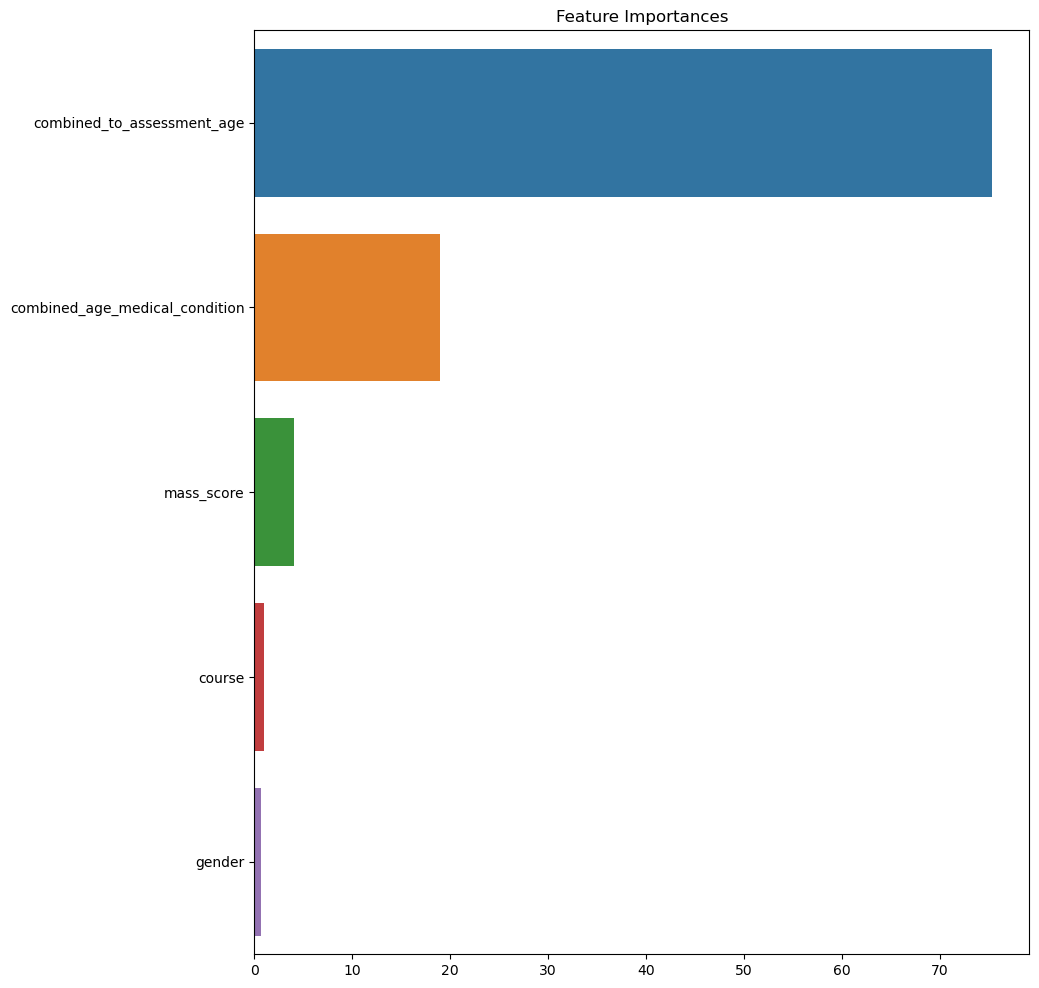

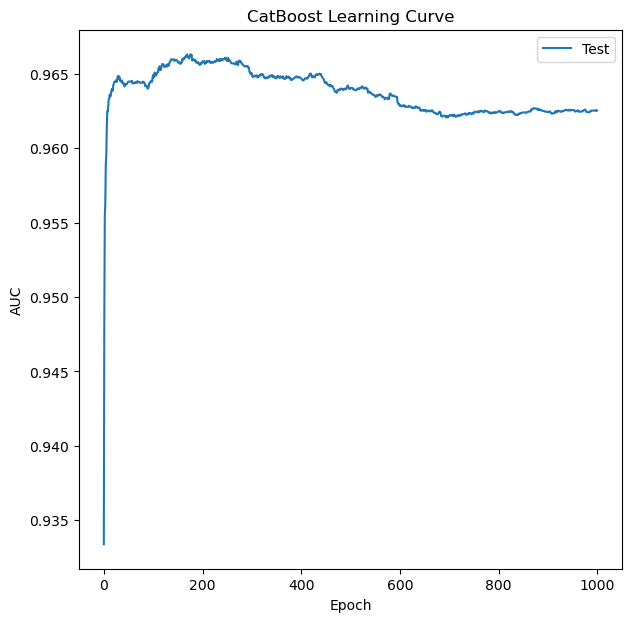

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 7))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Feature Importance
feature_importances = best_model.get_feature_importance()
sorted_indices = feature_importances.argsort()[::-1]
plt.figure(figsize=(10, 12))
plt.title("Feature Importances")
sns.barplot(y=X_train.columns[sorted_indices], x=feature_importances[sorted_indices])
plt.show()

# Learning Curve (if you have stored the evaluation results during training)
results = best_model.get_evals_result()
epochs = len(results['validation']['AUC'])
x_axis = range(0, epochs)
plt.figure(figsize=(7, 7))
plt.plot(x_axis, results['validation']['AUC'], label='Test')
plt.title('CatBoost Learning Curve')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()
